<a href="https://www.kaggle.com/code/melikesevin/dl-fishclassification?scriptVersionId=203165960" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
#necessary libraries used in the project
import numpy as np 
import pandas as pd
import seaborn as sns
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
from pathlib import Path
from sklearn.model_selection import train_test_split 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
import struct
import warnings
warnings.filterwarnings('ignore')
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Rescaling
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from keras.metrics import Recall, Precision
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD, RMSprop



**Data Preprocessing**

In [2]:
label = []
path = []

read = Path('../input/a-large-scale-fish-dataset/Fish_Dataset/Fish_Dataset')

for dir_name, _, filenames in os.walk(read):
    for filename in filenames:
        if os.path.splitext(filename)[-1] == '.png':
            if 'GT' not in dir_name.split('/')[-1]:
                label.append(os.path.split(dir_name)[-1])
                path.append(os.path.join(dir_name, filename))

df = pd.DataFrame(columns=['path', 'label'])
df['path'] = path
df['label'] = label
df.head()


,path,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel


This code iterates through a specified directory and its subdirectories to locate all .png image files. For each image, it extracts the label from the directory name and stores both the image path and the extracted label in a list. Subsequently, these lists are converted into a DataFrame.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    9000 non-null   object
 1   label   9000 non-null   object
dtypes: object(2)
memory usage: 140.8+ KB


The DataFrame contains 9000 rows, each representing a observation. It has 2 columns, which correspond to features. Additionally, the observations are of object type and contain no null values.

In [4]:
df

,path,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Hourse Mackerel
...,...,...
8995,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
8996,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
8997,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
8998,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream


When we look at the df above, that the fish images are in a sequential order. This situation may cause the model to learn the first few types better while neglecting the other types, leading to incorrect generalizations. By shuffling the data, we aim to ensure that the model sees images from each type equally, leading to better generalization.

In [5]:
df = df.sample(frac=1).reset_index(drop = True)

df.head()

,path,label
0,../input/a-large-scale-fish-dataset/Fish_Datas...,Shrimp
1,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
2,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat
3,../input/a-large-scale-fish-dataset/Fish_Datas...,Red Sea Bream
4,../input/a-large-scale-fish-dataset/Fish_Datas...,Black Sea Sprat


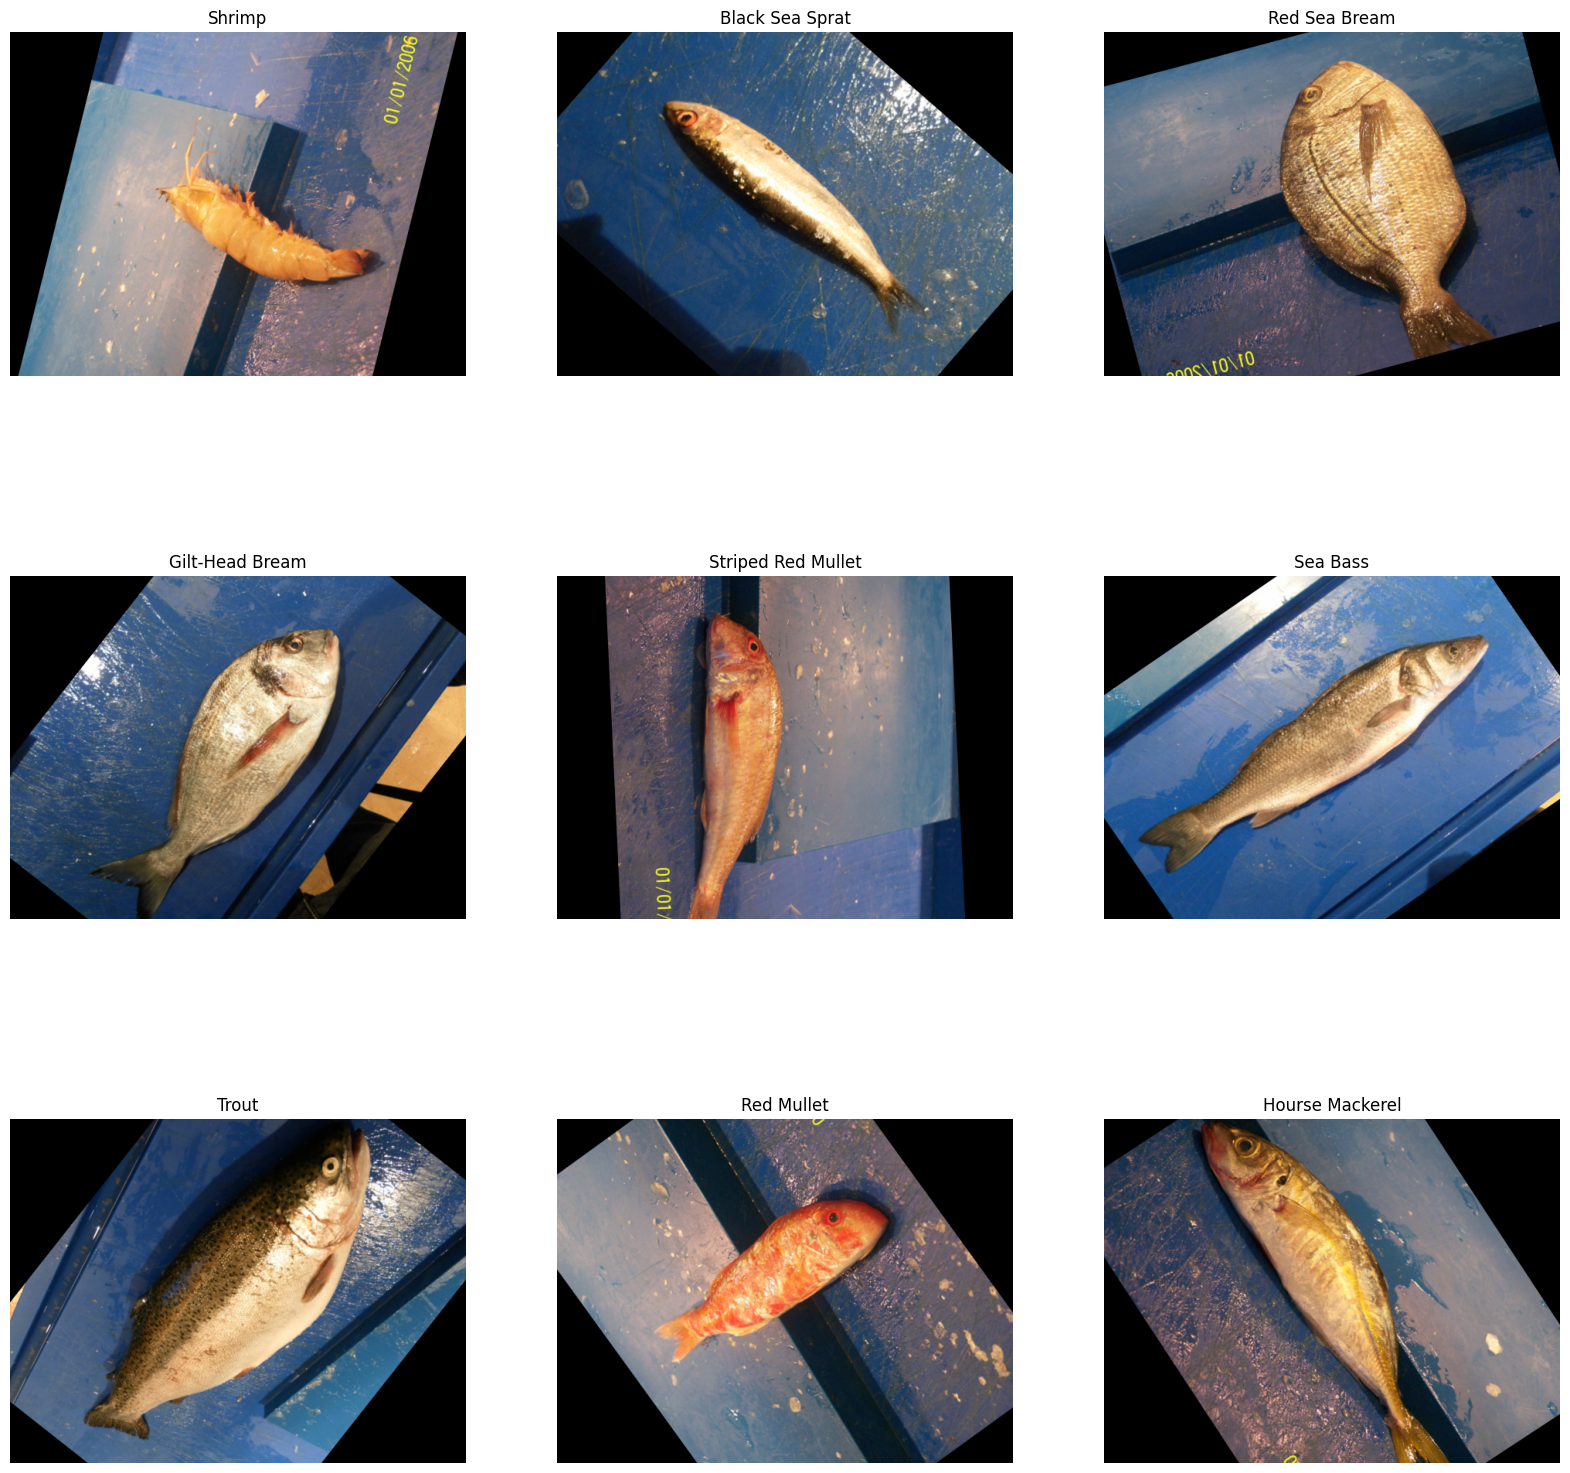

In [6]:
cn = 0
plt.figure(figsize=(20,20))

for unique_label in df['label'].unique():
    plt.subplot(3, 3, cn+1)
    img_path = df[df['label'] == unique_label]['path'].iloc[0]
    img = mpimg.imread(img_path)
    plt.imshow(img)
    plt.title(unique_label)
    plt.axis('off')
    cn += 1

plt.show()



Unique observations (fish species) were visualized along with their labels on a 3x3 grid.

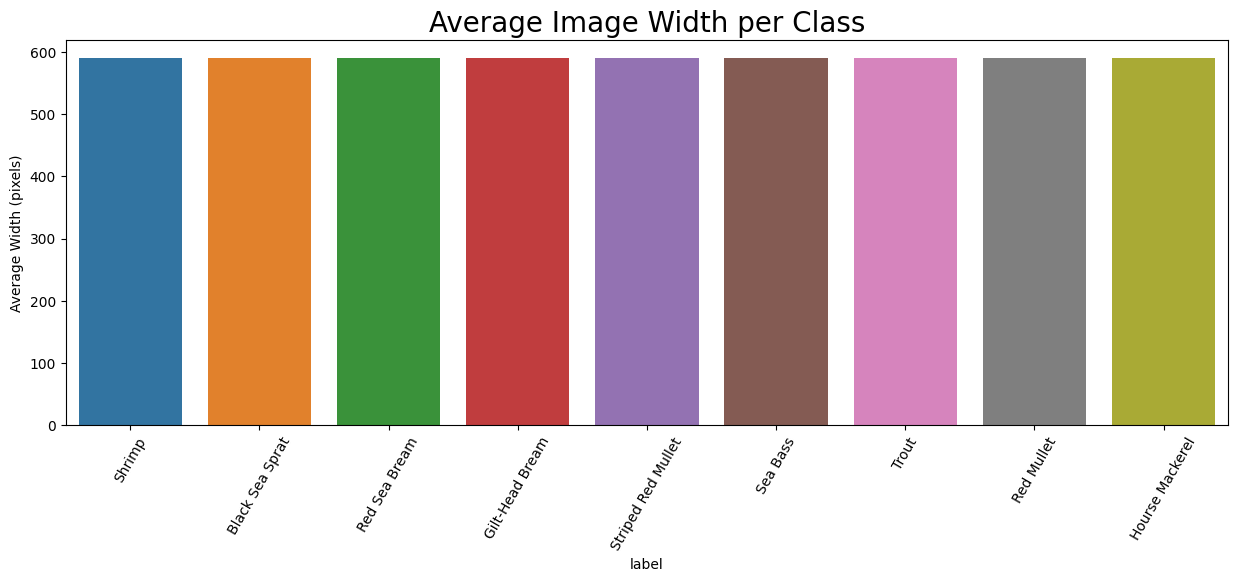

In [7]:
df['image_size'] = df['path'].apply(lambda x: Image.open(x).size)

df['width'] = df['image_size'].apply(lambda x: x[0])
df['height'] = df['image_size'].apply(lambda x: x[1])

plt.figure(figsize=(15,5))
sns.barplot(x=df['label'], y=df['width'], estimator=np.mean, ci=None)
plt.xticks(rotation=60)
plt.title('Average Image Width per Class', size=20)
plt.ylabel('Average Width (pixels)')
plt.show()


The code computes the dimensions (width and height) of images within the DataFrame and creates a visualization. A bar chart illustrates the mean width of images for each fish class. The uniform height of all bars indicates that, on average, images across all classes have the same width. After examining the graph, we can drop the 'image_size', 'width', and 'height' columns as they are no longer necessary.

In [8]:
df.drop(columns=['image_size', 'width', 'height'], inplace=True)


In [9]:
df.label.value_counts()

label
Shrimp                1000
Black Sea Sprat       1000
Red Sea Bream         1000
Gilt-Head Bream       1000
Striped Red Mullet    1000
Sea Bass              1000
Trout                 1000
Red Mullet            1000
Hourse Mackerel       1000
Name: count, dtype: int64

There are 9 types of fish and 1000 observations of each fish. The classes are balanced in the dataset.

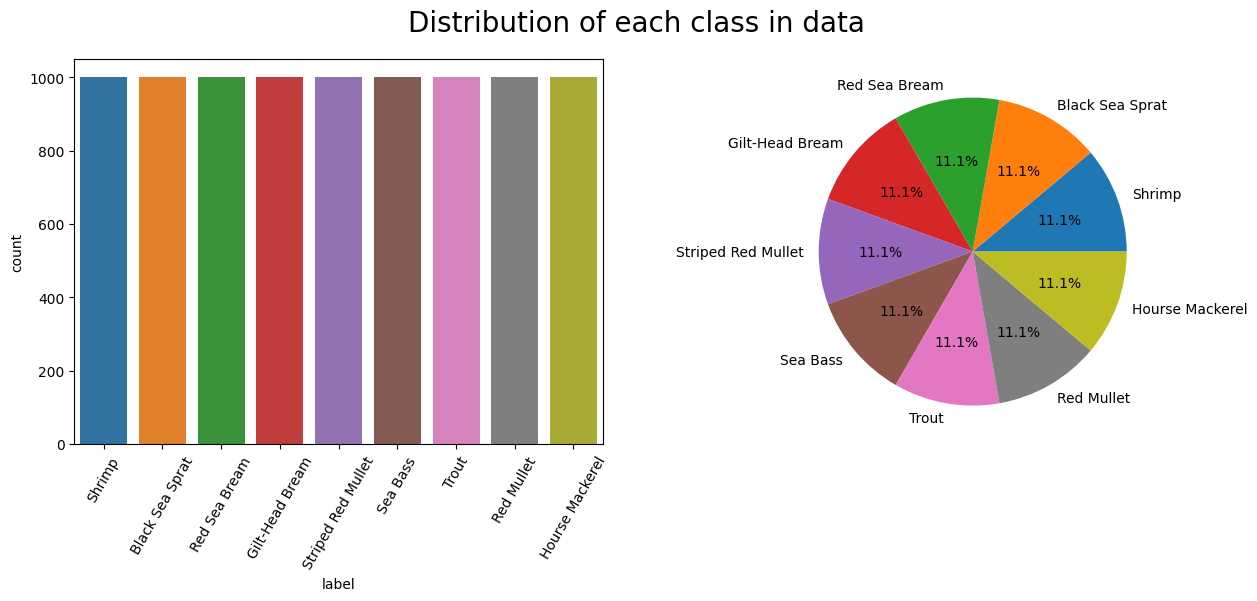

In [10]:
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
sns.countplot(data=df, x='label')
plt.xticks(rotation=60)

plt.subplot(1,2,2)
plt.pie(x=df['label'].value_counts().values, 
        labels=df['label'].value_counts().index, 
        autopct='%1.1f%%')

plt.suptitle('Distribution of each class in data', size=20)

plt.show()


These two graphs provide visual confirmation of the uniform distribution of the data.

In [11]:
train, test = train_test_split(df, train_size=0.8, shuffle=True, random_state=42)

train, valid = train_test_split(train, train_size=0.75, shuffle=True, random_state=42)

print(f'Shape of Training Data: {train.shape}')
print(f'Shape of Validation Data: {valid.shape}')
print(f'Shape of Testing Data: {test.shape}')


Shape of Training Data: (5400, 2)
Shape of Validation Data: (1800, 2)
Shape of Testing Data: (1800, 2)


Training Data: The training data has a shape of (5400, 2), meaning it consists of 5400 samples and 2 features. It will be used to train the model.

Validation Data: The validation data has a shape of (1800, 2), consisting of 1800 samples and 2 features. This dataset will be used to monitor the model's performance during training.

Testing Data: The testing data has a shape of (1800, 2), comprising 1800 samples and 2 features. This dataset will be used to evaluate the overall performance of the model.

**Training the Model**

In [12]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

img_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input  
)

img_size = (224, 224)

train_images = img_datagen.flow_from_dataframe(
    dataframe=train,
    x_col='path',  
    y_col='label',  
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

valid_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input  
)

valid_images = valid_datagen.flow_from_dataframe(
    dataframe=valid,
    x_col='path',  
    y_col='label',  
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input 
)

test_images = test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='path', 
    y_col='label',  
    target_size=img_size,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False  
)


Found 5400 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


This code establishes a data pipeline to prepare training and testing data for an image classification project using TensorFlow and Keras. Initially, an ImageDataGenerator object is defined to apply preprocessing suitable for the MobileNetV2 model. For the training set, the flow_from_dataframe method is used to load image files from the 'train' DataFrame, specifying the 'path' and 'label' columns. Images are resized to 224x224 pixels and set to RGB color mode. The order of images is shuffled during training. Subsequently, a similar ImageDataGenerator object is created for the test set, loading image files from the 'test' DataFrame using the 'path' and 'label' columns. The shuffle parameter is set to False for the test set to prevent shuffling, as it's crucial to maintain the original order of data when evaluating model performance on the test set. Shuffling the training data (shuffle=True) is beneficial as it exposes the model to different data orders in each epoch, enhancing learning. However, the test set remains unshuffled because preserving the original order during evaluation provides a more accurate assessment of the model's performance. Consequently, both training and test sets are equipped with the necessary data for image classification.

When examining the results, there are a total of 5400 valid image files in the training set, belonging to 9 different classes. These images will be used to train the model. Additionally, the validation set consists of 1800 valid image files, also belonging to 9 different classes, which will be used to tune the model's parameters during training. The test set contains another 1800 valid image files from the same 9 classes. After training, the model's performance will be evaluated using these test images.

In [13]:
def create_model(num_layers=2, num_units=128, dropout_rate=0.3, optimizer='adam'):
    model = Sequential()
    model.add(Rescaling(1./255, input_shape=(224, 224, 3)))
    

    for _ in range(num_layers):
        model.add(Flatten())
        model.add(Dense(num_units, activation='relu'))
        model.add(Dropout(dropout_rate))
    

    model.add(Dense(9, activation='softmax')) 
    

    if optimizer == 'adam':
        model.compile(optimizer=Adam(), loss="categorical_crossentropy", metrics=["accuracy", Recall(), Precision()])
    elif optimizer == 'sgd':
        model.compile(optimizer=SGD(), loss="categorical_crossentropy", metrics=["accuracy", Recall(), Precision()])
    elif optimizer == 'rmsprop':
        model.compile(optimizer=RMSprop(), loss="categorical_crossentropy", metrics=["accuracy", Recall(), Precision()])
    
    return model

model = create_model(num_layers=2, num_units=128, dropout_rate=0.3, optimizer='adam')


Model Definition and Layer Addition:
The Sequential() function is used to initialize the model as a sequential structure. This structure allows for the sequential addition of model layers.
The first layer used is Rescaling(1./255). This converts the pixel values of the images from the range 0-255 to the range 0-1. This enables the model to learn more efficiently during training.
The input shape is defined as input_shape=(224, 224, 3), indicating that the model's input is a 224x224 pixel, 3-channel (RGB) color image.

Hidden Layers:
A loop, for _ in range(num_layers), is used to add a specified number of hidden layers to the model. For example, if num_layers=2, this code adds 2 hidden layers.
In each layer, the following steps occur:

Flatten(): Flattens the 2D image data into a 1D vector.
Dense(num_units, activation='relu'): Adds a fully connected layer. Each neuron in this layer uses the ReLU activation function, and the number of neurons is determined by num_units (e.g., 128).
Dropout(dropout_rate): A Dropout layer is added to prevent overfitting by randomly disabling some neurons. A dropout rate (e.g., 30%) is used to randomly set neurons to zero.
Output Layer:
Dense(9, activation='softmax'): The final layer is added for 9 classes. The softmax activation provides the probability of belonging to each class. Here, 9 classes represent categories like fish species.

Model Compilation:
The model is compiled using different optimization algorithms depending on the optimizer argument:

'adam': Uses the Adam optimization algorithm.
'sgd': Uses SGD (Stochastic Gradient Descent).
'rmsprop': Uses RMSprop. Loss Function: categorical_crossentropy is used. This is a common loss function for multi-class classification problems. Metrics: The model's accuracy, recall, and precision are used to measure its performance. These are important metrics for understanding the model's performance.
Model Call:
When the create_model() function is called, a model is created with the given parameters. For example, here a model is defined using num_layers=2, num_units=128, dropout_rate=0.3, and optimizer='adam'.

**The model was initially tested with SGD and RMSprop optimizers, but both resulted in direct overfitting. Therefore, the Adam optimizer was selected for further training to improve model performance and generalization.**


In [14]:
print('Model summary :')
print()
model.summary()

Model summary :



Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 150528)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    19,267,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,285,385 (73.57 MB)

 Trainable params: 19,285,385 (73.57 MB)

 Non-trainable params: 0 (0.00 B)

Flatten: Layer that flattens the data into a one-dimensional vector. This layer flattens the input images. A 224x224x3 image is transformed into a single vector of size 150528. It also has no parameters as it only performs a structural transformation.

Dense (3 layers): Fully connected layers. These layers are the main parts where the model learns. The first dense layer contains 128 neurons and takes a 150528-dimensional vector as input. This layer contains 19,267,712 trainable parameters. These parameters consist of weights and bias terms. The second dense layer also contains 128 neurons and has 128 inputs. It contains 16,512 trainable parameters (Dense_1). The output layer makes predictions for 9 classes (fish species) using the softmax activation function. This layer has 1,161 trainable parameters (Dense_2).

Dropout (2 layers): Layers used to prevent overfitting. This layer applies a 30% dropout rate. By temporarily disabling some of the weights, it tries to prevent overfitting. It has no trainable parameters.

The model comprises a total of 57,856,157 learnable parameters. These parameters are adjusted during the training phase to align the model with the dataset. Out of the total, 19,285,385 parameters are actively updated during training. The model does not contain any fixed, non-adjustable parameters. Additionally, there are 38,570,772 optimization-related parameters that guide the weight update process within the optimization algorithm. 

In [15]:
history = model.fit(
    train_images, 
    validation_data=valid_images,
    epochs=10
)


Epoch 1/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 109s 612ms/step - accuracy: 0.2807 - loss: 1.9334 - precision: 0.5901 - recall: 0.0421 - val_accuracy: 0.5433 - val_loss: 1.2656 - val_precision: 0.7858 - val_recall: 0.2956
Epoch 2/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 104s 601ms/step - accuracy: 0.5759 - loss: 1.2094 - precision: 0.7442 - recall: 0.3398 - val_accuracy: 0.7067 - val_loss: 0.9451 - val_precision: 0.8524 - val_recall: 0.4878
Epoch 3/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 105s 604ms/step - accuracy: 0.6733 - loss: 0.9328 - precision: 0.8068 - recall: 0.5117 - val_accuracy: 0.7550 - val_loss: 0.7448 - val_precision: 0.8479 - val_recall: 0.6289
Epoch 4/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 107s 616ms/step - accuracy: 0.7321 - loss: 0.7455 - precision: 0.8421 - recall: 0.6317 - val_accuracy: 0.8044 - val_loss: 0.6025 - val_precision: 0.8786 - val_recall: 0.7156
Epoch 5/10
169/169 ━━━━━━━━━━━━━━━━━━━━ 108s 620ms/step - accuracy: 0.7948 - loss: 0.6063 - precision: 0.8633 - recall: 0.7137 - val_accuracy: 0

Accuracy: At the end of the training process, the model achieved an accuracy of 91.51%. This indicates that the model has a generally good classification ability.
The accuracy on the validation set also reached 92.22%, suggesting that the model performs well on new, unseen data.

Loss Decrease: The training loss decreased consistently in each epoch. It dropped from 1.9522 in Epoch 1 to 0.2431 in Epoch 10. This indicates that the model's learning process was effective.

Precision and Recall: On the training data, precision reached 93.55% and recall reached 89.25%. This shows that the model is quite successful in identifying positive classes.
On the validation data, precision was 93.12% and recall was 91.00%. This also reveals that the model exhibits similar success on different datasets.

Improvement Process: Throughout the training process, a significant increase was observed in both precision and recall values of the model. This indicates that the model acquired more information over time and made better decisions.

In [16]:
results = model.evaluate(test_images)

test_loss = results[0]
test_acc = results[1]
test_recall = results[2]
test_precision = results[3]

print(f'Test Loss: {test_loss}')
print(f'Test Accuracy: {test_acc}')
print(f'Test Recall: {test_recall}')
print(f'Test Precision: {test_precision}')


57/57 ━━━━━━━━━━━━━━━━━━━━ 23s 398ms/step - accuracy: 0.9077 - loss: 0.2680 - precision: 0.9304 - recall: 0.8932
Test Loss: 0.29091355204582214
Test Accuracy: 0.898888885974884
Test Recall: 0.882777750492096
Test Precision: 0.9238371849060059


Test Loss: The test loss is determined to be 0.259. This indicates that the model still performs effectively on the test data and the overall error rate is low.

Test Accuracy: The test accuracy is 90.78%. This shows that the model has a high rate of correct predictions on the test dataset and the overall performance of the model is good.

Test Recall: The test recall value is 89.72%. This indicates that the model has a very good ability to identify positive classes and that the model has a high rate of capturing true positive instances. However, the fact that this value is below 90% suggests that the model may miss some positive instances.

Test Precision: The test precision is 92.13%. This shows how much of the model's positive predictions are actually correct. A high precision indicates that the model is reliable in its positive predictions and that the false positive rate is low.

<Figure size 1000x500 with 0 Axes>

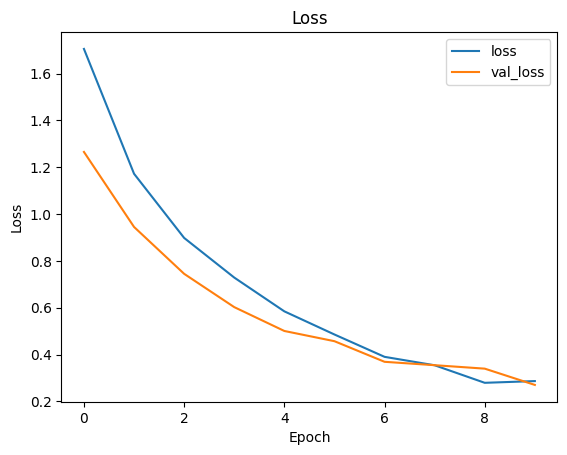

<Figure size 1000x500 with 0 Axes>

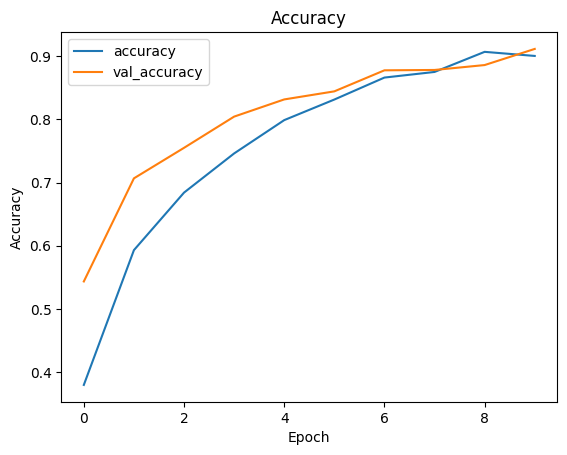

<Figure size 1000x500 with 0 Axes>

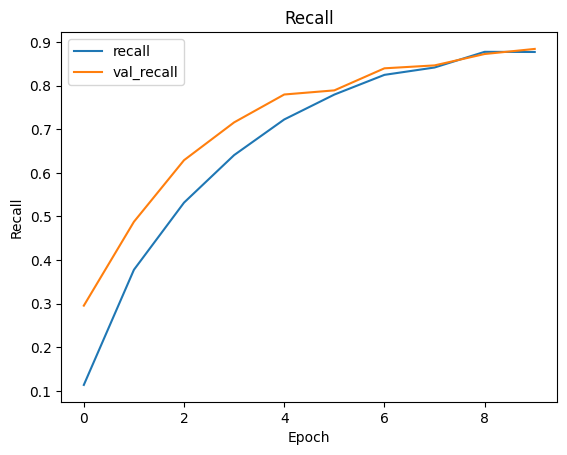

<Figure size 1000x500 with 0 Axes>

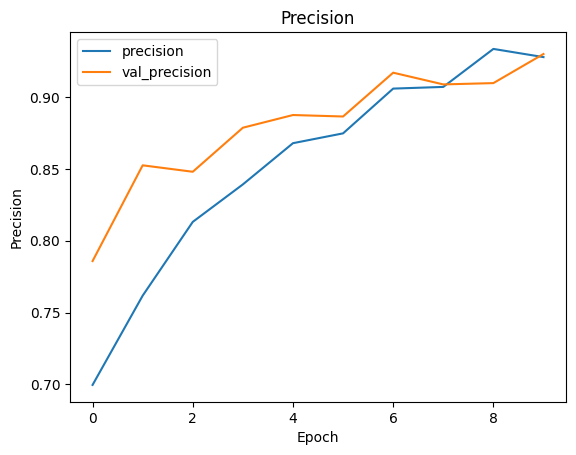

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

# Loss
plt.figure(figsize=(10, 5))
pd.DataFrame(history.history)[['loss', 'val_loss']].plot()
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

# Accuracy
plt.figure(figsize=(10, 5))
pd.DataFrame(history.history)[['accuracy', 'val_accuracy']].plot()
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

# Recall
plt.figure(figsize=(10, 5))
pd.DataFrame(history.history)[['recall', 'val_recall']].plot()
plt.title("Recall")
plt.xlabel("Epoch")
plt.ylabel("Recall")
plt.legend()
plt.show()

# Precision
plt.figure(figsize=(10, 5))
pd.DataFrame(history.history)[['precision', 'val_precision']].plot()
plt.title("Precision")
plt.xlabel("Epoch")
plt.ylabel("Precision")
plt.legend()
plt.show()


As the training progresses, both the training and validation losses decrease, suggesting that the model is learning. Additionally, the overall increase in accuracy, precision, and recall metrics indicates that the model is making more accurate predictions, better identifying positive cases, and becoming more confident in its positive classifications.